**last update: 07/16/2024**  

This notebook is for Bayesian Gaussian process regression test.

Dataset: 5*5 spatial average in Kenya. CMIP5 annually, 1850 -2100. 15 models.

Design: GPR function and hyperparameter tuning. Try different ways to search for best parameters. Also find correlation between these data with ENSO index.

# Package

In [1]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, ConstantKernel as C
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, ParameterGrid
from scipy.optimize import minimize
from pyswarm import pso
from bayes_opt import BayesianOptimization
from scipy.linalg import cholesky, cho_solve,cho_factor,solve_triangular

# Kernel Function

In [2]:
def compute_KGCM(GCM_data, Nobs):

    # prepending observed data to GCM_Data
    tmp = np.vstack((GCM_data.iloc[:Nobs,:], GCM_data))

    # compute smoothed covariance and mean
    smoothedCov = np.cov(tmp, rowvar = True)
    
    KGCM = (16/15)*smoothedCov

    return KGCM

In [3]:
def compute_KNoise(GCM_data, Nobs, sigma1, sigma2, sigma3):   # this is a RBF(short-term autocorrelations) + white noise 
     
     # create noise matrix
    length = len(GCM_data) + Nobs
    col_index, row_index = np.meshgrid(np.arange(length),np.arange(length))
    Noise_matrix = sigma1**2 * np.exp(-(1/(2*sigma2**2)) *(col_index - row_index) **2) + sigma3**2 * np.eye(length)


    return Noise_matrix

In [4]:
def Choleskey_trick(A, b, K_os):
     # solve Ax = b for x, x = A-1b
     # solve Av = K_os for v
  
     
     c,low = cho_factor(A, lower = True)
     x = cho_solve((c, low), b)
     L = cholesky(A, lower=True) # this is the lower triangular cholesky matrix
     v = solve_triangular(L,K_os, lower= True)
    

     
     return x, v,L

In [5]:
def GPR_func(obs, Nobs, GCM_data, sigma1, sigma2, sigma3, sigma_n, period5, period10, amp5, amp10, use_cholesky=False):

        # prepending length of observed data to GCM_Data
        tmp = np.vstack((GCM_data.iloc[:Nobs, :], GCM_data))
        smoothedMean = np.mean(tmp, axis=1)

        # develop kernel
        KGCM = compute_KGCM(GCM_data, Nobs)
        KNoise = compute_KNoise(GCM_data, Nobs, sigma1, sigma2, sigma3)
        
        periodic_kernel_5 = amp5 * ExpSineSquared(length_scale=sigma1, periodicity=period5)
        periodic_kernel_10 = amp10 * ExpSineSquared(length_scale=sigma2, periodicity=period10)

        # Prepare data for periodic kernels
        X_train = np.arange(len(GCM_data) + Nobs).reshape(-1, 1)

        # Calculate periodic kernels
        K_periodic_5 = periodic_kernel_5(X_train, X_train)
        K_periodic_10 = periodic_kernel_10(X_train, X_train)

        # Combine kernels
        K = KGCM + KNoise + K_periodic_5 + K_periodic_10
        K += 1e-6 * np.eye(K.shape[0])
        # prepare data for GPR
        y = obs[:Nobs]
        mu = smoothedMean[:Nobs]  # prior estimate mean(up to observations)
        mu_s = smoothedMean[Nobs:]  # prior estimate mean (whole study period)
        
        Noise = sigma_n * np.eye(Nobs, Nobs)  # noise only add on diagonal
        
        # subset kernel
        K_o = K[:Nobs, :Nobs]
        K_s = K[Nobs:, Nobs:]
        K_os = K[:Nobs, Nobs:]

        # compute the difference between prior mean and obs
        diff = y - mu  # observations deviates from its prior estimate mean
        if diff.ndim == 1:
            diff = diff[:, np.newaxis]  # convert diff into a 2D array, make sure dimension match in later matrix multiplication

        if not use_cholesky:
            eigenvalues = np.linalg.eigvalsh(K_o + Noise)
            assert np.all(eigenvalues >= 0)
            f = mu_s + K_os.T @ np.linalg.inv(K_o + Noise) @ diff.ravel()
            Sigma_s = K_s - K_os.T @ np.linalg.inv(K_o + Noise) @ K_os
            lml = -0.5 * (diff.T @ np.linalg.inv(K_o + Noise) @ diff + np.log(np.linalg.det(K_o + Noise))).item()
        else:
            A = K_o + Noise
            eigenvalues = np.linalg.eigvalsh(A)
            assert np.all(eigenvalues >= 0)
            alpha, v, L = Choleskey_trick(A, diff, K_os)
            f = mu_s + np.dot(K_os.T, alpha).ravel()
            Sigma_s = K_s - np.dot(v.T, v)
            lml = -0.5 * (np.dot(diff.T, alpha) + 2 * np.sum(np.log(np.diag(L)))).item()

        prior_mu = mu_s
        prior_cov = K_s
        post_mu = f
        post_cov = Sigma_s

        return prior_mu, prior_cov, post_mu, post_cov, lml


In [6]:
def tune_GPR(sig1, sig2, sig3, period5, period10, amp5, amp10, mod_ids, Nobs, FiveYrDf, smoothed_50yrDf, FiveYr_anom, use_cholesky=False, Fiveyr=False):

    Marginal_Likelihood = np.zeros((len(sig1), len(sig2), len(sig3), len(period5), len(period10), len(amp5), len(amp10)))
    total_iterations = len(mod_ids) * len(sig1) * len(sig2) * len(sig3) * len(period5) * len(period10) * len(amp5) * len(amp10)
    progress_bar = tqdm(total=total_iterations, desc="Tuning GPR parameters")
    
    for mod_id in mod_ids:
        oos_gcm = FiveYrDf.iloc[:, mod_id].values
        column_indices = [i for i in range(smoothed_50yrDf.shape[1]) if i != 0 and i != mod_id]
        if Fiveyr:
            GCM_data = smoothed_50yrDf.iloc[::5, column_indices]
        else:
            GCM_data = smoothed_50yrDf.iloc[:, column_indices]
        sigma_n = FiveYr_anom.iloc[:Nobs, mod_id].var()

        for ii in range(len(sig1)):
            for jj in range(len(sig2)):
                for kk in range(len(sig3)):
                    for pp5 in range(len(period5)):
                        for pp10 in range(len(period10)):
                            for mm in range(len(amp5)):
                                for nn in range(len(amp10)):

                                    sigma1 = sig1[ii]
                                    sigma2 = sig2[jj]
                                    sigma3 = sig3[kk]
                                    p5 = period5[pp5]
                                    p10 = period10[pp10]
                                    a5 = amp5[mm]
                                    a10 = amp10[nn]

                                    try:
                                        prior_mu, prior_cov, post_mu, post_cov, lml = GPR_func(
                                            oos_gcm, Nobs, GCM_data, sigma1, sigma2, sigma3, sigma_n, p5, p10, a5, a10, use_cholesky
                                        )
                                        if np.isreal(lml):
                                            Marginal_Likelihood[ii, jj, kk, pp5, pp10, mm, nn] += lml
                                        else:
                                            Marginal_Likelihood[ii, jj, kk, pp5, pp10, mm, nn] = -np.inf
                                    except np.linalg.LinAlgError as e:
                                        Marginal_Likelihood[ii, jj, kk, pp5, pp10, mm, nn] = -np.inf
                                    progress_bar.update(1)

    progress_bar.close()

    max_idx = np.argmax(Marginal_Likelihood)
    a, b, c, d, e, f, g = np.unravel_index(max_idx, Marginal_Likelihood.shape)
    Max_Likelihood_sigma1 = sig1[a]
    Max_Likelihood_sigma2 = sig2[b]
    Max_Likelihood_sigma3 = sig3[c]
    Max_Likelihood_period5 = period5[d]
    Max_Likelihood_period10 = period10[e]
    Max_Likelihood_amp5 = amp5[f]
    Max_Likelihood_amp10 = amp10[g]

    return Max_Likelihood_sigma1, Max_Likelihood_sigma2, Max_Likelihood_sigma3, Max_Likelihood_period5, Max_Likelihood_period10, Max_Likelihood_amp5, Max_Likelihood_amp10



In [7]:
def custom_kernel_factory(sigma1, sigma2, sigma3, period5, period10, amp5, amp10, GCM_data, Nobs):
    KGCM = compute_KGCM(GCM_data, Nobs)
    KNoise = compute_KNoise(GCM_data, Nobs, sigma1, sigma2, sigma3)
    periodic_kernel_5 = amp5 * ExpSineSquared(length_scale=sigma1, periodicity=period5)
    periodic_kernel_10 = amp10 * ExpSineSquared(length_scale=sigma2, periodicity=period10)

    X_train = np.arange(len(GCM_data) + Nobs).reshape(-1, 1)
    K_periodic_5 = periodic_kernel_5(X_train, X_train)
    K_periodic_10 = periodic_kernel_10(X_train, X_train)

    K = KGCM + KNoise + K_periodic_5 + K_periodic_10
    K += 1e-6 * np.eye(K.shape[0])
    return K

In [8]:
def tune_GPR_RandomizedSearchCV(sig1, sig2, sig3, period5, period10, amp5, amp10, mod_ids, Nobs, FiveYrDf, smoothed_50yrDf, FiveYr_anom, use_cholesky=False, Fiveyr=False):
    best_params_list = []
    total_iterations = len(mod_ids) * len(sig1) * len(sig2) * len(sig3) * len(period5) * len(period10) * len(amp5) * len(amp10)
    progress_bar = tqdm(total=total_iterations, desc="Tuning GPR parameters")

    for mod_id in mod_ids:
        oos_gcm = FiveYrDf.iloc[:, mod_id].values
        column_indices = [i for i in range(smoothed_50yrDf.shape[1]) if i != 0 and i != mod_id]
        if Fiveyr:
            GCM_data = smoothed_50yrDf.iloc[::5, column_indices]
        else:
            GCM_data = smoothed_50yrDf.iloc[:, column_indices]
        sigma_n = FiveYr_anom.iloc[:Nobs, mod_id].var()

        def custom_kernel(sigma1, sigma2, sigma3, period5, period10, amp5, amp10):
            progress_bar.update(1)
            return custom_kernel_factory(sigma1, sigma2, sigma3, period5, period10, amp5, amp10, GCM_data, Nobs)

        gpr = GaussianProcessRegressor()

        param_distributions = {
            'kernel': [custom_kernel(sigma1, sigma2, sigma3, p5, p10, a5, a10) for sigma1 in sig1 for sigma2 in sig2 for sigma3 in sig3 for p5 in period5 for p10 in period10 for a5 in amp5 for a10 in amp10]
        }

        random_search = RandomizedSearchCV(estimator=gpr, param_distributions=param_distributions, n_iter=100, cv=3, verbose=1, n_jobs=-1, error_score='raise')
        X = np.arange(Nobs).reshape(-1, 1)
        y = oos_gcm[:Nobs]

        random_search.fit(X, y)

        best_params = random_search.best_params_
        best_params_list.append(best_params)

    progress_bar.close()

    return best_params_list

# Data

In [9]:
FiveYrDf_cmip5 = pd.read_csv('../data/week2/YrDf_cmip5_2300.csv')
smoothed_50yrDf_cmip5 = pd.read_csv('../data/week2/smoothed_50yrDf_cmip5_2300.csv')
FiveYr_anom_cmip5 = pd.read_csv('../data/week2/YrDf_anom_cmip5_2300.csv')

In [10]:
YrDf_cmip5 = pd.read_csv('../data/week2/YrDf_cmip5_2300.csv') 
YrDf_anom_cmip5 = pd.read_csv('../data/week2/YrDf_anom_cmip5_2300.csv')

In [11]:
# use 50-year smooth average to develop priors
GCM_data = pd.DataFrame(smoothed_50yrDf_cmip5.iloc[:, 2:])# take 15 GCMs
#GCM_data = pd.DataFrame(FiveYrDf_all.iloc[:, 2:])
print("years in GCM data: ", len(GCM_data), "number of GCMs:", GCM_data.shape[1])

# use 5-yr average as observations
oos_gcm = YrDf_cmip5.iloc[:,1].values

print("years in oos GCM for virtual observations:",len(oos_gcm)) # total 250 years

# observations year 
Nobs = np.where(YrDf_cmip5["years"] ==2020)[0][0]  
#Nobs = 25  # from 1870-2000, 5*Nobs
print("length of annual data has been observed:", Nobs)

# compute the variance of the observation residuals
stdObs = YrDf_anom_cmip5["model_0"].iloc[:Nobs].var()
print("var of observation residuals is : ", stdObs)

years in GCM data:  400 number of GCMs: 15
years in oos GCM for virtual observations: 400
length of annual data has been observed: 145
var of observation residuals is :  0.9114296186654598


# Hyperparameter Tuning

## Original

In [9]:
sig1 = np.arange(0, 0.5, 0.1)
sig2 = np.arange(0.1, 3, 0.5)
sig3 = np.arange(0, 0.5, 0.2)
period5 = np.arange(3, 7, 1) # 5-year period
period10 = np.arange(9, 11, 1)  # 10-year period
amp5 = np.arange(0.1, 1, 0.5)
amp10 = np.arange(0.1, 1, 0.5)

mod_ids = np.arange(1, 17, 1)  # 16 GCM models
print(len(sig1), len(sig2), len(sig3), len(amp5), len(amp10))

Nobs_tune = np.where(YrDf_cmip5["years"] == 2020)[0][0]


5 6 3 2 2


In [10]:
best_params = tune_GPR(sig1, sig2, sig3, period5, period10, amp5, amp10, mod_ids, Nobs_tune, YrDf_cmip5, smoothed_50yrDf_cmip5, YrDf_anom_cmip5, use_cholesky=False, Fiveyr=False)
print("Best parameters:", best_params)

Tuning GPR parameters:   0%|          | 0/46080 [00:00<?, ?it/s]d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR parameters: 100%|██████████| 46080/46080 [1:33:46<00:00,  8.19it/s]   

Best parameters: (0.2, 1.1, 0.0, 3, 10, 0.1, 0.1)


In [12]:
max_sigma1, max_sigma2, max_sigma3, max_period5, max_period10, max_amp5, max_amp10 = best_params
print(max_sigma1, max_sigma2, max_sigma3)
print(max_period5, max_period10)
print(max_amp5, max_amp10)

0.2 1.1 0.0
3 10
0.1 0.1


In [16]:
# use 50-year smooth average to develop priors
GCM_data = pd.DataFrame(smoothed_50yrDf_cmip5.iloc[:, 2:])# take 15 GCMs
#GCM_data = pd.DataFrame(FiveYrDf_all.iloc[:, 2:])
print("years in GCM data: ", len(GCM_data), "number of GCMs:", GCM_data.shape[1])

# use 5-yr average as observations
oos_gcm = YrDf_cmip5.iloc[:,1].values

print("years in oos GCM for virtual observations:",len(oos_gcm)) # total 250 years

# observations year 
Nobs = np.where(YrDf_cmip5["years"] ==2020)[0][0]  
#Nobs = 25  # from 1870-2000, 5*Nobs
print("length of annual data has been observed:", Nobs)

# compute the variance of the observation residuals
stdObs = YrDf_anom_cmip5["model_0"].iloc[:Nobs].var()
print("var of observation residuals is : ", stdObs)

years in GCM data:  400 number of GCMs: 15
years in oos GCM for virtual observations: 400
length of annual data has been observed: 145
var of observation residuals is :  0.9114296186654598


In [18]:
prior_mu, prior_cov, post_mu, post_cov,lml = GPR_func(oos_gcm, Nobs, GCM_data, max_sigma1, max_sigma2, max_sigma3, max_period5, max_period10, max_amp5, max_amp10, stdObs, use_cholesky=False)

In [19]:
print(lml)

-106.58323629501652


In [20]:
assert np.all(np.diag(post_cov) >= 0)

assert np.allclose(post_cov, post_cov.T, atol=1e-8)
eigenvalues = np.linalg.eigvalsh(post_cov)
print("Smallest eigenvalues:", np.sort(eigenvalues)[:10])
assert np.all(eigenvalues >= 0)

Smallest eigenvalues: [0.00057072 0.00057388 0.00057558 0.00057957 0.00058114 0.00058474
 0.00058587 0.0005909  0.00060603 0.00061857]


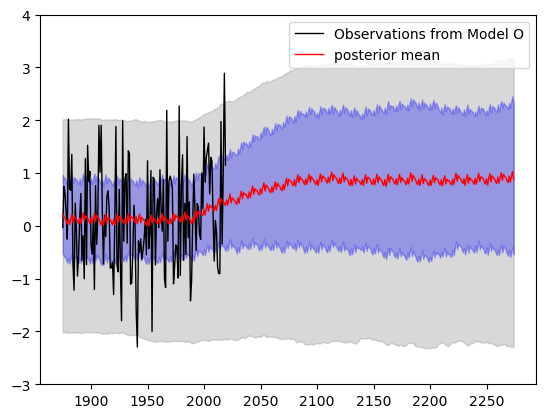

In [23]:
prior_std = np.sqrt(np.diag(prior_cov))
post_std = np.sqrt(np.diag(post_cov))

plt.figure()

FiveYrDf = YrDf_cmip5

#plot observations from model O  (1850 -2020)
plt.plot(FiveYrDf["years"][:Nobs].values, oos_gcm[:Nobs], 'k', lw = 1, label='Observations from Model O')

# plot prior mean and 95% CI  (1850 - 2099)
plt.fill_between(FiveYrDf["years"].values, prior_mu - 1.96*prior_std, prior_mu + 1.96*prior_std, alpha=0.3,color='gray')

# plot posterior mean and 95% CI (2020 - 2099)
#plt.fill_between(FiveYrDf["years"].values[Nobs:], post_mu[Nobs:] - 1.96*post_std[Nobs:], post_mu[Nobs:]+ 1.96*post_std[Nobs:], alpha=0.3,color='blue')

#plt.plot(FiveYrDf["years"].values[Nobs:], post_mu[Nobs:] ,'r', lw = 1, label='posterior mean')

# only plot post mean for prediction year (after 2000)
t_pred = FiveYrDf["years"].values[Nobs:]
post_mu_pred = post_mu[Nobs:]
post_std_pred = post_std[Nobs:]



# plot post mean for the whole study period
t_pred = FiveYrDf["years"].values
post_mu_pred = post_mu
post_std_pred = post_std

plt.fill_between(t_pred, post_mu_pred - 1.96*post_std_pred, post_mu_pred + 1.96*post_std_pred, alpha=0.3,color='blue')
plt.plot(t_pred, post_mu_pred ,'r', lw = 1, label='posterior mean')
plt.ylim(-3, 4)

plt.legend()
plt.show()

## ParameterGrid Search

In [50]:
def tune_GPR_ParameterGrid(sig1, sig2, sig3, period5, period10, amp5, amp10, mod_ids, Nobs, FiveYrDf, smoothed_50yrDf, FiveYr_anom, use_cholesky=False, Fiveyr=False):
    param_grid = {
        'sigma1': sig1,
        'sigma2': sig2,
        'sigma3': sig3,
        'period5': period5,
        'period10': period10,
        'amp5': amp5,
        'amp10': amp10
    }
    param_combinations = list(ParameterGrid(param_grid))
    
    best_params_list = []
    total_iterations = len(mod_ids) * len(param_combinations)
    progress_bar = tqdm(total=total_iterations, desc="Tuning GPR parameters")
    
    for mod_id in mod_ids:
        oos_gcm = FiveYrDf.iloc[:, mod_id].values
        column_indices = [i for i in range(smoothed_50yrDf.shape[1]) if i != 0 and i != mod_id]
        if Fiveyr:
            GCM_data = smoothed_50yrDf.iloc[::5, column_indices]
        else:
            GCM_data = smoothed_50yrDf.iloc[:, column_indices]
        sigma_n = FiveYr_anom.iloc[:Nobs, mod_id].var()
        
        best_lml = -np.inf
        best_params = None

        for params in param_combinations:
            sigma1 = params['sigma1']
            sigma2 = params['sigma2']
            sigma3 = params['sigma3']
            period5 = params['period5']
            period10 = params['period10']
            amp5 = params['amp5']
            amp10 = params['amp10']

            try:
                prior_mu, prior_cov, post_mu, post_cov, lml = GPR_func(
                    oos_gcm, Nobs, GCM_data, sigma1, sigma2, sigma3, sigma_n, period5, period10, amp5, amp10, use_cholesky
                )
                if np.isreal(lml) and lml > best_lml:
                    best_lml = lml
                    best_params = params
            except np.linalg.LinAlgError as e:
                continue
            except ValueError as e:
                print(f"Error with params {params}: {e}")
                continue

            progress_bar.update(1)

        best_params_list.append(best_params)
        
    progress_bar.close()

    return best_params_list

In [52]:
sig1 = np.arange(0, 0.2, 0.05)
sig2 = np.arange(0.1, 3, 0.5)
sig3 = [0]
period5 = [3] 
period10 = [10]  
amp5 = np.arange(0.1, 0.5, 0.1)
amp10 = np.arange(0.1, 0.5, 0.1)

In [ ]:
best_params = tune_GPR_ParameterGrid(sig1, sig2, sig3, period5, period10, amp5, amp10, mod_ids, Nobs_tune, YrDf_cmip5, smoothed_50yrDf_cmip5, YrDf_anom_cmip5, use_cholesky=False, Fiveyr=False)
print("Best parameters:", best_params)

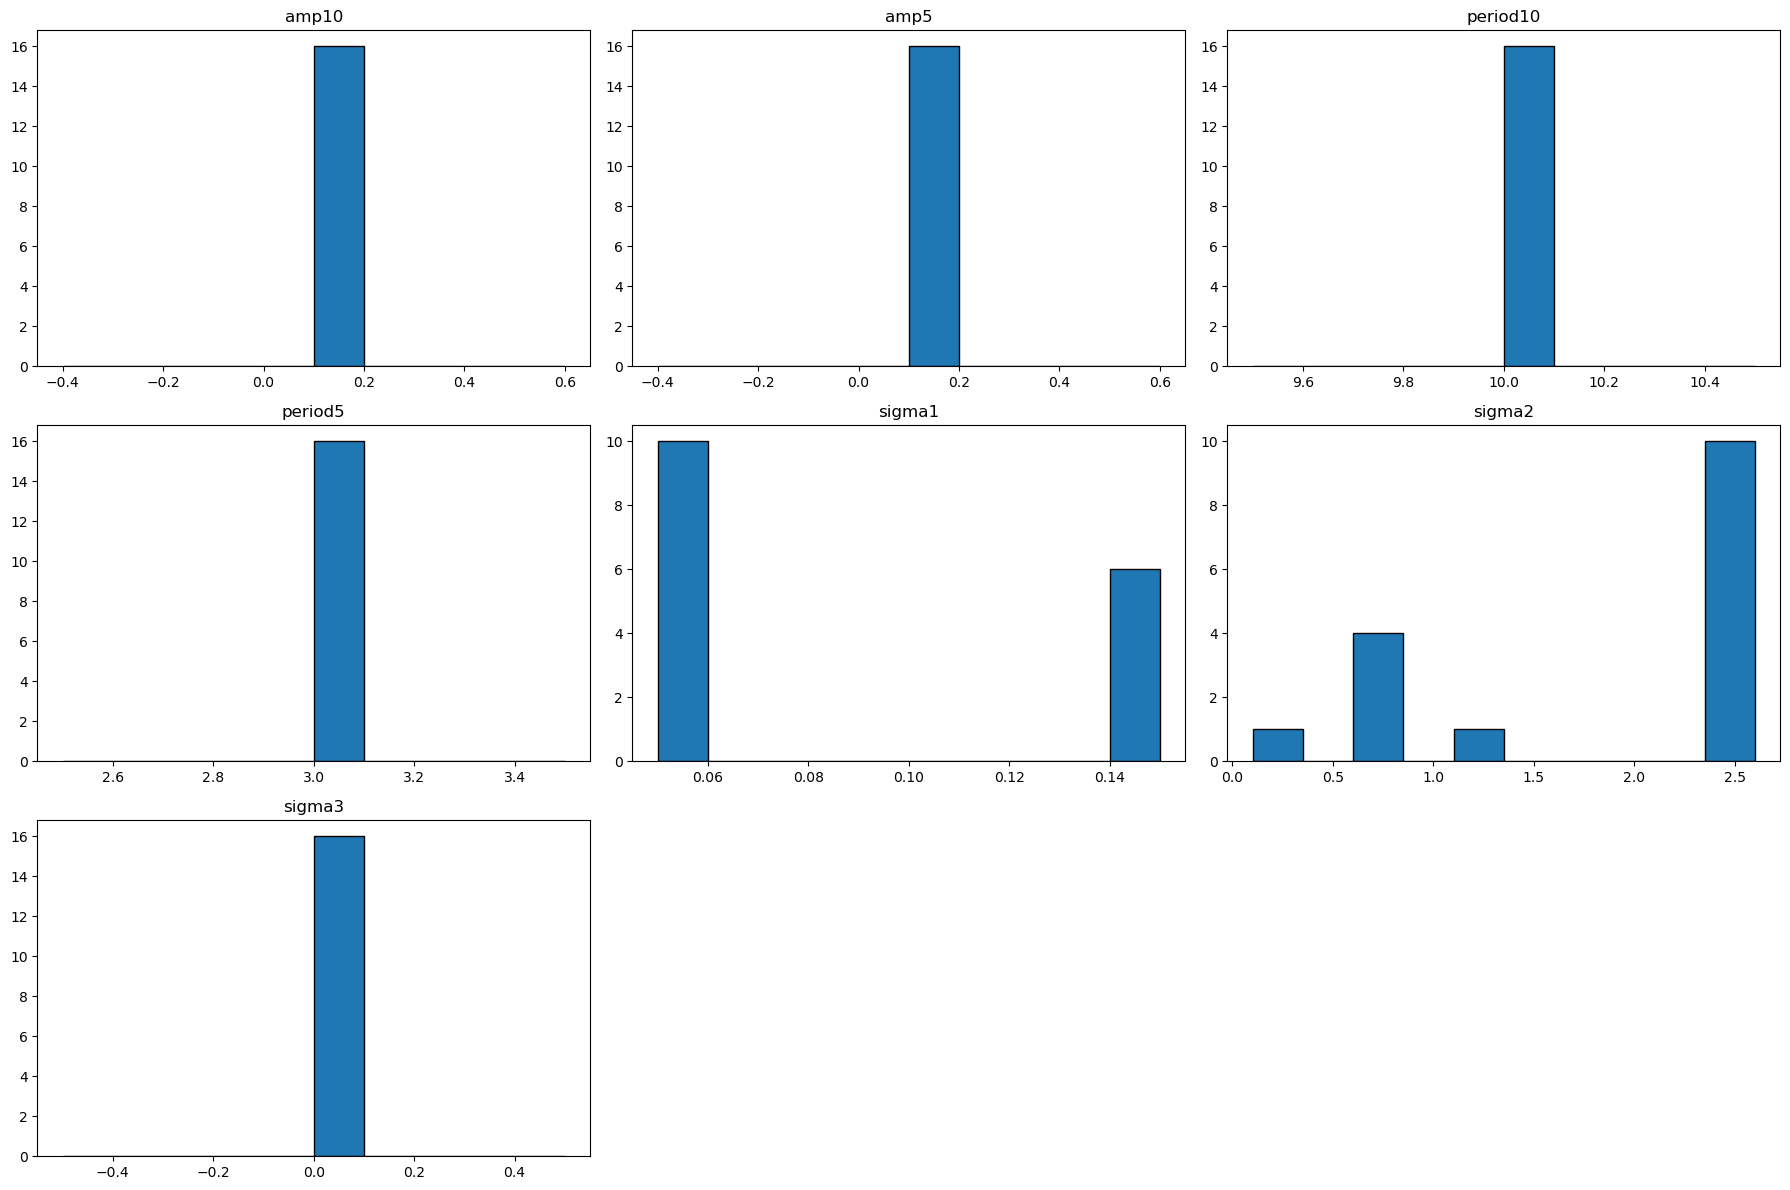

Most common parameters: {'amp10': 0.1, 'amp5': 0.1, 'period10': 10.0, 'period5': 3.0, 'sigma1': 0.05, 'sigma2': 2.6, 'sigma3': 0.0}


In [43]:
best_params = [
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.15000000000000002, 'sigma2': 2.6, 'sigma3': 0},
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.05, 'sigma2': 2.6, 'sigma3': 0},
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.15000000000000002, 'sigma2': 1.1, 'sigma3': 0},
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.05, 'sigma2': 2.6, 'sigma3': 0},
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.05, 'sigma2': 0.6, 'sigma3': 0},
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.05, 'sigma2': 2.6, 'sigma3': 0},
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.05, 'sigma2': 2.6, 'sigma3': 0},
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.15000000000000002, 'sigma2': 2.6, 'sigma3': 0},
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.05, 'sigma2': 0.6, 'sigma3': 0},
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.15000000000000002, 'sigma2': 2.6, 'sigma3': 0},
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.05, 'sigma2': 0.1, 'sigma3': 0},
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.15000000000000002, 'sigma2': 2.6, 'sigma3': 0},
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.05, 'sigma2': 0.6, 'sigma3': 0},
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.15000000000000002, 'sigma2': 2.6, 'sigma3': 0},
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.05, 'sigma2': 2.6, 'sigma3': 0},
    {'amp10': 0.1, 'amp5': 0.1, 'period10': 10, 'period5': 3, 'sigma1': 0.05, 'sigma2': 0.6, 'sigma3': 0}
]

amp10_values = [param['amp10'] for param in best_params]
amp5_values = [param['amp5'] for param in best_params]
period10_values = [param['period10'] for param in best_params]
period5_values = [param['period5'] for param in best_params]
sigma1_values = [param['sigma1'] for param in best_params]
sigma2_values = [param['sigma2'] for param in best_params]
sigma3_values = [param['sigma3'] for param in best_params]

plt.figure(figsize=(18, 12))

plt.subplot(3, 3, 1)
plt.hist(amp10_values, bins=10, edgecolor='black')
plt.title('amp10')

plt.subplot(3, 3, 2)
plt.hist(amp5_values, bins=10, edgecolor='black')
plt.title('amp5')

plt.subplot(3, 3, 3)
plt.hist(period10_values, bins=10, edgecolor='black')
plt.title('period10')

plt.subplot(3, 3, 4)
plt.hist(period5_values, bins=10, edgecolor='black')
plt.title('period5')

plt.subplot(3, 3, 5)
plt.hist(sigma1_values, bins=10, edgecolor='black')
plt.title('sigma1')

plt.subplot(3, 3, 6)
plt.hist(sigma2_values, bins=10, edgecolor='black')
plt.title('sigma2')

plt.subplot(3, 3, 7)
plt.hist(sigma3_values, bins=10, edgecolor='black')
plt.title('sigma3')

plt.tight_layout()
plt.show()

params_df = pd.DataFrame(best_params)

most_common_params = params_df.mode().iloc[0].to_dict()
print("Most common parameters:", most_common_params)


In [44]:
amp10_best = most_common_params['amp10']
amp5_best = most_common_params['amp5']
period10_best = most_common_params['period10']
period5_best = most_common_params['period5']
sigma1_best = most_common_params['sigma1']
sigma2_best = most_common_params['sigma2']
sigma3_best = most_common_params['sigma3']

In [53]:
prior_mu, prior_cov, post_mu, post_cov,lml = GPR_func(oos_gcm, Nobs, GCM_data, sigma1_best, sigma2_best, sigma3_best, 0, period5_best, period10_best, amp5_best, amp10_best,use_cholesky = False)

C:\Users\Whisky\AppData\Local\Temp\ipykernel_11464\1484322790.py:46: RuntimeWarning: divide by zero encountered in log
  lml = -0.5 * (diff.T @ np.linalg.inv(K_o + Noise) @ diff + np.log(np.linalg.det(K_o + Noise))).item()


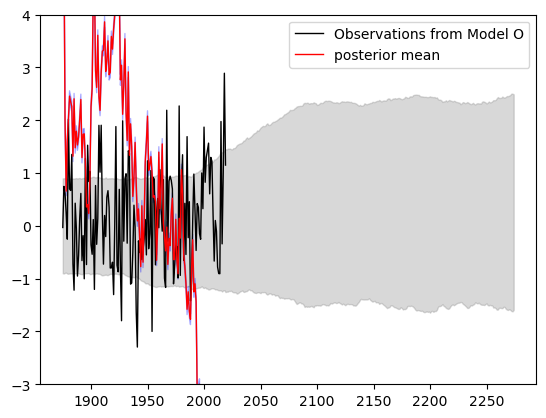

In [54]:
prior_std = np.sqrt(np.diag(prior_cov))
post_std = np.sqrt(np.diag(post_cov))

plt.figure()

FiveYrDf = YrDf_cmip5

#plot observations from model O  (1850 -2020)
plt.plot(FiveYrDf["years"][:Nobs].values, oos_gcm[:Nobs], 'k', lw = 1, label='Observations from Model O')

# plot prior mean and 95% CI  (1850 - 2099)
plt.fill_between(FiveYrDf["years"].values, prior_mu - 1.96*prior_std, prior_mu + 1.96*prior_std, alpha=0.3,color='gray')

# plot posterior mean and 95% CI (2020 - 2099)
#plt.fill_between(FiveYrDf["years"].values[Nobs:], post_mu[Nobs:] - 1.96*post_std[Nobs:], post_mu[Nobs:]+ 1.96*post_std[Nobs:], alpha=0.3,color='blue')

#plt.plot(FiveYrDf["years"].values[Nobs:], post_mu[Nobs:] ,'r', lw = 1, label='posterior mean')

# only plot post mean for prediction year (after 2000)
t_pred = FiveYrDf["years"].values[Nobs:]
post_mu_pred = post_mu[Nobs:]
post_std_pred = post_std[Nobs:]



# plot post mean for the whole study period
t_pred = FiveYrDf["years"].values
post_mu_pred = post_mu
post_std_pred = post_std

plt.fill_between(t_pred, post_mu_pred - 1.96*post_std_pred, post_mu_pred + 1.96*post_std_pred, alpha=0.3,color='blue')
plt.plot(t_pred, post_mu_pred ,'r', lw = 1, label='posterior mean')
plt.ylim(-3, 4)

plt.legend()
plt.show()

## Minimize

In [65]:
def objective(params, obs, Nobs, GCM_data, sigma_n, use_cholesky):
    sigma1, sigma2, sigma3, period5, period10, amp5, amp10 = params
    _, _, _, _, lml = GPR_func(obs, Nobs, GCM_data, sigma1, sigma2, sigma3, sigma_n, period5, period10, amp5, amp10, use_cholesky)
    return -lml

initial_params = [0.1, 1.0, 0.1, 5, 10, 0.5, 0.5] 
bounds = [(0, 1), (0.1, 3), (0, 0.5), (3, 7), (9, 11), (0.1, 1), (0.1, 1)] 

result = minimize(objective, initial_params, args=(oos_gcm, Nobs, GCM_data, 0, False), bounds=bounds, method='L-BFGS-B')
optimal_params = result.x
print("Optimal parameters:", optimal_params)

Optimal parameters: [0.7715754  0.10000719 0.5        6.90989887 9.         0.1
 0.1       ]


In [68]:
sigma1_minimize_opt = optimal_params[0]
sigma2_minimize_opt = optimal_params[1]
sigma3_minimize_opt = optimal_params[2]
period5_minimize_opt = optimal_params[3]
period10_minimize_opt = optimal_params[4]
amp5_minimize_opt = optimal_params[5]
amp10_minimize_opt = optimal_params[6]
prior_mu_minimize_opt, prior_cov_minimize_opt, post_mu_minimize_opt, post_cov_minimize_opt,lml_minimize_opt = GPR_func(oos_gcm, Nobs, GCM_data, sigma1_minimize_opt, sigma2_minimize_opt, sigma3_minimize_opt, 0, period5_minimize_opt, period10_minimize_opt, amp5_minimize_opt, amp10_minimize_opt,use_cholesky = False)

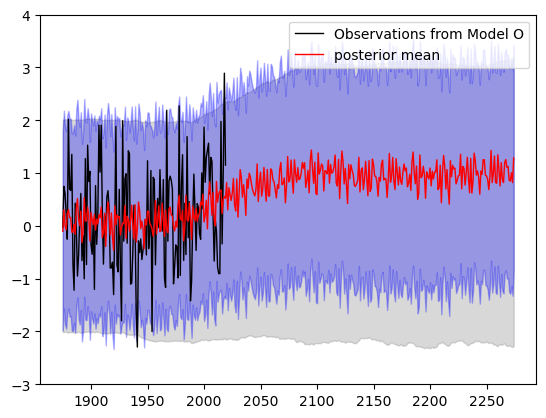

In [69]:
prior_std = np.sqrt(np.diag(prior_cov_minimize_opt))
post_std = np.sqrt(np.diag(post_cov_minimize_opt))

plt.figure()

FiveYrDf = YrDf_cmip5

#plot observations from model O  (1850 -2020)
plt.plot(FiveYrDf["years"][:Nobs].values, oos_gcm[:Nobs], 'k', lw = 1, label='Observations from Model O')

# plot prior mean and 95% CI  (1850 - 2099)
plt.fill_between(FiveYrDf["years"].values, prior_mu - 1.96*prior_std, prior_mu + 1.96*prior_std, alpha=0.3,color='gray')

# plot posterior mean and 95% CI (2020 - 2099)
#plt.fill_between(FiveYrDf["years"].values[Nobs:], post_mu[Nobs:] - 1.96*post_std[Nobs:], post_mu[Nobs:]+ 1.96*post_std[Nobs:], alpha=0.3,color='blue')

#plt.plot(FiveYrDf["years"].values[Nobs:], post_mu[Nobs:] ,'r', lw = 1, label='posterior mean')

# only plot post mean for prediction year (after 2000)
t_pred = FiveYrDf["years"].values[Nobs:]
post_mu_pred = post_mu_minimize_opt[Nobs:]
post_std_pred = post_std[Nobs:]



# plot post mean for the whole study period
t_pred = FiveYrDf["years"].values
post_mu_pred = post_mu_minimize_opt
post_std_pred = post_std

plt.fill_between(t_pred, post_mu_pred - 1.96*post_std_pred, post_mu_pred + 1.96*post_std_pred, alpha=0.3,color='blue')
plt.plot(t_pred, post_mu_pred ,'r', lw = 1, label='posterior mean')
plt.ylim(-3, 4)

plt.legend()
plt.show()

## PSO

In [12]:
total_iterations = 100 * 50 
progress_bar = tqdm(total=total_iterations, desc="Tuning GPR parameters")


def objective(params):
    sigma1, sigma2, sigma3, period5, period10, amp5, amp10 = params
    try:
        _, _, _, _, lml = GPR_func(oos_gcm, Nobs, GCM_data, sigma1, sigma2, sigma3, 0, period5, period10, amp5, amp10, use_cholesky=False)
        progress_bar.update(1) 
        return -lml
    except:
        progress_bar.update(1)
        return float('inf')

lb = [0, 0, 0, 2, 9, 0, 0]
ub = [10, 10, 1, 7, 20, 3, 3]##

optimal_params, _ = pso(objective, lb, ub, swarmsize=50, maxiter=100)
progress_bar.close()

print("Optimal parameters:", optimal_params)


Tuning GPR parameters:   1%|          | 57/5000 [00:07<10:51,  7.59it/s]C:\Users\Whisky\AppData\Local\Temp\ipykernel_3404\2605571939.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  Noise_matrix = sigma1**2 * np.exp(-(1/(2*sigma2**2)) *(col_index - row_index) **2) + sigma3**2 * np.eye(length)
C:\Users\Whisky\AppData\Local\Temp\ipykernel_3404\2605571939.py:6: RuntimeWarning: invalid value encountered in multiply
  Noise_matrix = sigma1**2 * np.exp(-(1/(2*sigma2**2)) *(col_index - row_index) **2) + sigma3**2 * np.eye(length)
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR paramete

Stopping search: maximum iterations reached --> 100
Optimal parameters: [ 3.42913239  5.28921661  0.          7.         15.73502002  0.
  1.75164874]


In [15]:
sigma1_pso_opt = optimal_params[0]
sigma2_pso_opt = optimal_params[1]
sigma3_pso_opt = optimal_params[2]
period5_pso_opt = optimal_params[3]
period10_pso_opt = optimal_params[4]
amp5_pso_opt = optimal_params[5]
amp10_pso_opt = optimal_params[6]
prior_mu_pso_opt, prior_cov_pso_opt, post_mu_pso_opt, post_cov_pso_opt,lml_pso_opt = GPR_func(oos_gcm, Nobs, GCM_data, sigma1_pso_opt, sigma2_pso_opt, sigma3_pso_opt, 0, period5_pso_opt, period10_pso_opt, amp5_pso_opt, amp10_pso_opt,use_cholesky = False)

C:\Users\Whisky\AppData\Local\Temp\ipykernel_3404\1484322790.py:46: RuntimeWarning: divide by zero encountered in log
  lml = -0.5 * (diff.T @ np.linalg.inv(K_o + Noise) @ diff + np.log(np.linalg.det(K_o + Noise))).item()


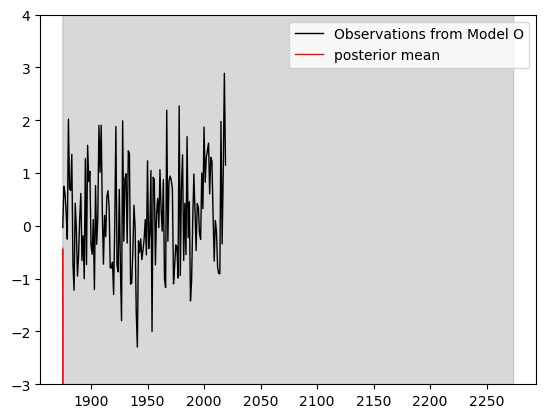

In [21]:
prior_std = np.sqrt(np.diag(prior_cov_pso_opt))
post_std = np.sqrt(np.diag(post_cov_pso_opt))

plt.figure()

FiveYrDf = YrDf_cmip5

#plot observations from model O  (1850 -2020)
plt.plot(FiveYrDf["years"][:Nobs].values, oos_gcm[:Nobs], 'k', lw = 1, label='Observations from Model O')

# plot prior mean and 95% CI  (1850 - 2099)
plt.fill_between(FiveYrDf["years"].values, prior_mu_pso_opt - 1.96*prior_std, prior_mu_pso_opt + 1.96*prior_std, alpha=0.3,color='gray')

# only plot post mean for prediction year (after 2000)
t_pred = FiveYrDf["years"].values[Nobs:]
post_mu_pred = post_mu_pso_opt[Nobs:]
post_std_pred = post_std[Nobs:]

# plot post mean for the whole study period
t_pred = FiveYrDf["years"].values
post_mu_pred = post_mu_pso_opt
post_std_pred = post_std

plt.fill_between(t_pred, post_mu_pred - 1.96*post_std_pred, post_mu_pred + 1.96*post_std_pred, alpha=0.3,color='blue')
plt.plot(t_pred, post_mu_pred ,'r', lw = 1, label='posterior mean')
plt.ylim(-3, 4)

plt.legend()
plt.show()

## Bayesian

In [26]:
def GPR_func(obs, Nobs, GCM_data, sigma1, sigma2, sigma3, sigma_n, period5, period10, amp5, amp10, use_cholesky=False):
    try:
        tmp = np.vstack((GCM_data.iloc[:Nobs, :], GCM_data))
        smoothedMean = np.mean(tmp, axis=1)
        KGCM = compute_KGCM(GCM_data, Nobs)
        KNoise = compute_KNoise(GCM_data, Nobs, sigma1, sigma2, sigma3)
        periodic_kernel_5 = amp5 * ExpSineSquared(length_scale=sigma1, periodicity=period5)
        periodic_kernel_10 = amp10 * ExpSineSquared(length_scale=sigma2, periodicity=period10)
        X_train = np.arange(len(GCM_data) + Nobs).reshape(-1, 1)
        K_periodic_5 = periodic_kernel_5(X_train, X_train)
        K_periodic_10 = periodic_kernel_10(X_train, X_train)
        K = KGCM + KNoise + K_periodic_5 + K_periodic_10
        K += 1e-6 * np.eye(K.shape[0])
        y = obs[:Nobs]
        mu = smoothedMean[:Nobs]
        mu_s = smoothedMean[Nobs:]
        Noise = sigma_n * np.eye(Nobs, Nobs)
        K_o = K[:Nobs, :Nobs]
        K_s = K[Nobs:, Nobs:]
        K_os = K[:Nobs, Nobs:]
        diff = y - mu
        if diff.ndim == 1:
            diff = diff[:, np.newaxis]
        if not use_cholesky:
            eigenvalues = np.linalg.eigvalsh(K_o + Noise)
            assert np.all(eigenvalues >= 0)
            f = mu_s + K_os.T @ np.linalg.inv(K_o + Noise) @ diff.ravel()
            Sigma_s = K_s - K_os.T @ np.linalg.inv(K_o + Noise) @ K_os
            lml = -0.5 * (diff.T @ np.linalg.inv(K_o + Noise) @ diff + np.log(np.linalg.det(K_o + Noise))).item()
        else:
            A = K_o + Noise
            eigenvalues = np.linalg.eigvalsh(A)
            assert np.all(eigenvalues >= 0)
            alpha, v, L = Choleskey_trick(A, diff, K_os)
            f = mu_s + np.dot(K_os.T, alpha).ravel()
            Sigma_s = K_s - np.dot(v.T, v)
            lml = -0.5 * (np.dot(diff.T, alpha) + 2 * np.sum(np.log(np.diag(L)))).item()
        prior_mu = mu_s
        prior_cov = K_s
        post_mu = f
        post_cov = Sigma_s
        return prior_mu, prior_cov, post_mu, post_cov, lml
    except Exception as e:
        print(f"Exception in GPR_func: {e}")
        return None, None, None, None, -1e6

total_iterations = 100  
progress_bar = tqdm(total=total_iterations, desc="Tuning GPR parameters")

def objective(sigma1, sigma2, sigma3, period5, period10, amp5, amp10):
    try:
        _, _, _, _, lml = GPR_func(oos_gcm, Nobs, GCM_data, sigma1, sigma2, sigma3, 0, period5, period10, amp5, amp10, use_cholesky=False)
        if np.isinf(lml) or np.isnan(lml):
            lml = -1e6 
        progress_bar.update(1)
        return lml
    except Exception as e:
        print(f"Exception: {e} for params: {sigma1}, {sigma2}, {sigma3}, {period5}, {period10}, {amp5}, {amp10}")
        progress_bar.update(1)
        return -1e6  


pbounds = {
    'sigma1': (0.0, 1.0),
    'sigma2': (0.1, 3.0),
    'sigma3': (0.0, 0.5),
    'period5': (3, 7),
    'period10': (9, 11),
    'amp5': (0.1, 1.0),
    'amp10': (0.1, 1.0)
}

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=20, 
    n_iter=total_iterations,
)

progress_bar.close()

print("Optimal parameters:", optimizer.max)


Tuning GPR parameters:   1%|          | 1/100 [00:00<00:13,  7.12it/s]

|   iter    |  target   |   amp10   |   amp5    | period10  |  period5  |  sigma1   |  sigma2   |  sigma3   |
-------------------------------------------------------------------------------------------------------------
| 1         | -1.375e+0 | 0.4753    | 0.7483    | 9.0       | 4.209     | 0.1468    | 0.3678    | 0.09313   |


Tuning GPR parameters:   3%|▎         | 3/100 [00:00<00:14,  6.78it/s]

| 2         | -84.2     | 0.411     | 0.4571    | 10.08     | 4.677     | 0.6852    | 0.6929    | 0.4391    |
| 3         | -201.6    | 0.1246    | 0.7034    | 9.835     | 5.235     | 0.1404    | 0.6745    | 0.4004    |


Tuning GPR parameters:   5%|▌         | 5/100 [00:00<00:12,  7.46it/s]

| 4         | -82.61    | 0.9714    | 0.3821    | 10.38     | 6.506     | 0.8946    | 0.3466    | 0.01953   |
| 5         | -205.0    | 0.2528    | 0.8903    | 9.197     | 4.684     | 0.9579    | 1.646     | 0.3459    |


Tuning GPR parameters:   7%|▋         | 7/100 [00:00<00:11,  8.06it/s]

| 6         | -225.3    | 0.384     | 0.7179    | 10.67     | 3.073     | 0.7501    | 2.968     | 0.3741    |
| 7         | -166.7    | 0.3524    | 0.8104    | 9.206     | 4.792     | 0.9086    | 0.9515    | 0.1439    |


Tuning GPR parameters:   9%|▉         | 9/100 [00:01<00:11,  8.15it/s]

| 8         | -1.841e+0 | 0.217     | 0.1174    | 10.36     | 3.847     | 0.2655    | 1.526     | 0.02668   |
| 9         | -324.9    | 0.6167    | 0.2321    | 10.18     | 5.799     | 0.1023    | 1.301     | 0.3472    |


Tuning GPR parameters:  11%|█         | 11/100 [00:01<00:11,  7.48it/s]

| 10        | -342.1    | 0.4728    | 0.145     | 10.07     | 5.655     | 0.5149    | 2.839     | 0.2933    |
| 11        | -106.2    | 0.9131    | 0.2237    | 9.279     | 6.23      | 0.3977    | 0.5795    | 0.4638    |


Tuning GPR parameters:  13%|█▎        | 13/100 [00:01<00:11,  7.46it/s]

| 12        | -933.0    | 0.413     | 0.7757    | 10.45     | 6.533     | 0.6237    | 2.278     | 0.1744    |
| 13        | -6.672e+0 | 0.3429    | 0.9063    | 9.856     | 6.859     | 0.6634    | 1.903     | 0.05737   |


Tuning GPR parameters:  15%|█▌        | 15/100 [00:01<00:11,  7.61it/s]

| 14        | -388.8    | 0.9545    | 0.5049    | 10.16     | 4.633     | 0.237     | 2.72      | 0.2868    |
| 15        | -116.7    | 0.1026    | 0.6554    | 9.653     | 5.108     | 0.8859    | 1.136     | 0.4543    |


Tuning GPR parameters:  17%|█▋        | 17/100 [00:02<00:12,  6.68it/s]

| 16        | -76.74    | 0.661     | 0.1142    | 10.86     | 5.764     | 0.9973    | 0.5998    | 0.06857   |
| 17        | -235.4    | 0.9393    | 0.7271    | 9.132     | 6.022     | 0.7539    | 2.777     | 0.3558    |


Tuning GPR parameters:  19%|█▉        | 19/100 [00:02<00:12,  6.48it/s]

| 18        | -389.6    | 0.2118    | 0.1179    | 9.052     | 3.113     | 0.2462    | 2.594     | 0.2694    |
| 19        | -405.9    | 0.5975    | 0.8578    | 9.248     | 4.117     | 0.5858    | 2.912     | 0.2805    |


Tuning GPR parameters:  20%|██        | 20/100 [00:02<00:14,  5.36it/s]

| 20        | -204.3    | 0.1168    | 0.8206    | 9.466     | 6.228     | 0.3879    | 2.604     | 0.3736    |


Tuning GPR parameters:  21%|██        | 21/100 [00:03<00:19,  4.14it/s]d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR parameters:  22%|██▏       | 22/100 [00:03<00:17,  4.46it/s]

| 21        | -92.6     | 0.9211    | 0.638     | 9.898     | 5.355     | 1.0       | 0.1209    | 0.5       |
Exception in GPR_func: Eigenvalues did not converge
| 22        | -1e+06    | 1.0       | 1.0       | 10.51     | 5.846     | 0.0       | 3.0       | 0.5       |


Tuning GPR parameters:  23%|██▎       | 23/100 [00:04<00:27,  2.79it/s]

| 23        | -5.166e+0 | 0.1       | 0.1       | 9.621     | 5.826     | 1.0       | 2.165     | 0.0       |


Tuning GPR parameters:  24%|██▍       | 24/100 [00:04<00:25,  3.01it/s]

| 24        | -4.237e+0 | 0.4745    | 0.7307    | 10.7      | 4.386     | 0.6807    | 1.904     | 0.002494  |


Tuning GPR parameters:  26%|██▌       | 26/100 [00:05<00:28,  2.58it/s]

| 25        | -95.08    | 0.4599    | 0.6945    | 9.652     | 5.092     | 0.69      | 0.6345    | 0.3561    |
| 26        | -83.59    | 0.4165    | 0.6821    | 9.825     | 5.531     | 0.7548    | 0.4201    | 0.1295    |


Tuning GPR parameters:  27%|██▋       | 27/100 [00:06<00:35,  2.07it/s]

| 27        | -124.7    | 0.8624    | 0.2272    | 10.24     | 5.774     | 0.3201    | 0.4147    | 0.5       |


Tuning GPR parameters:  28%|██▊       | 28/100 [00:06<00:36,  1.99it/s]

| 28        | -119.4    | 0.1603    | 0.6855    | 9.499     | 4.246     | 0.2206    | 1.208     | 0.4923    |


Tuning GPR parameters:  29%|██▉       | 29/100 [00:07<00:38,  1.87it/s]

| 29        | -147.2    | 0.7376    | 1.0       | 10.11     | 6.32      | 0.3463    | 0.8721    | 0.4351    |


Tuning GPR parameters:  30%|███       | 30/100 [00:07<00:31,  2.22it/s]

| 30        | -440.4    | 0.4915    | 0.563     | 10.11     | 4.815     | 0.7318    | 1.965     | 0.2533    |


Tuning GPR parameters:  31%|███       | 31/100 [00:08<00:37,  1.84it/s]

| 31        | -131.0    | 0.9366    | 0.8501    | 9.815     | 4.878     | 0.2224    | 1.392     | 0.5       |


Tuning GPR parameters:  32%|███▏      | 32/100 [00:08<00:33,  2.00it/s]

| 32        | -1.946e+0 | 0.3429    | 0.8874    | 9.185     | 4.531     | 0.8185    | 2.173     | 0.03436   |


Tuning GPR parameters:  33%|███▎      | 33/100 [00:08<00:29,  2.28it/s]

| 33        | -79.11    | 0.4321    | 0.7191    | 9.821     | 5.53      | 0.8453    | 0.3842    | 0.1375    |


Tuning GPR parameters:  34%|███▍      | 34/100 [00:09<00:37,  1.75it/s]

| 34        | -156.4    | 0.5904    | 1.0       | 9.324     | 7.0       | 0.152     | 2.747     | 0.5       |


Tuning GPR parameters:  35%|███▌      | 35/100 [00:10<00:43,  1.50it/s]

| 35        | -119.8    | 0.9548    | 0.3812    | 9.556     | 3.874     | 0.7424    | 1.902     | 0.5       |


d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR parameters:  36%|███▌      | 36/100 [00:11<00:45,  1.42it/s]

Exception in GPR_func: Eigenvalues did not converge
| 36        | -1e+06    | 0.1698    | 1.0       | 10.54     | 7.0       | 0.0       | 1.689     | 0.5       |


Tuning GPR parameters:  38%|███▊      | 38/100 [00:11<00:27,  2.23it/s]

| 37        | -436.4    | 0.8997    | 0.706     | 9.087     | 6.032     | 0.853     | 2.64      | 0.2635    |
| 38        | -224.2    | 0.6415    | 0.7109    | 9.641     | 3.927     | 0.1155    | 0.6101    | 0.3815    |


Tuning GPR parameters:  39%|███▉      | 39/100 [00:12<00:23,  2.62it/s]

| 39        | -126.2    | 0.5321    | 0.7773    | 9.02      | 5.241     | 0.9606    | 0.9056    | 0.2138    |


Tuning GPR parameters:  40%|████      | 40/100 [00:13<00:31,  1.93it/s]

| 40        | -128.9    | 0.1       | 1.0       | 9.657     | 3.401     | 0.664     | 2.144     | 0.5       |


Tuning GPR parameters:  41%|████      | 41/100 [00:13<00:25,  2.33it/s]

| 41        | -134.9    | 0.4084    | 0.3646    | 9.835     | 6.375     | 0.136     | 1.496     | 0.4929    |


d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR parameters:  42%|████▏     | 42/100 [00:13<00:27,  2.12it/s]

Exception in GPR_func: Eigenvalues did not converge
| 42        | -1e+06    | 0.1       | 0.2063    | 9.869     | 3.987     | 0.0       | 2.551     | 0.5       |


Tuning GPR parameters:  43%|████▎     | 43/100 [00:14<00:31,  1.83it/s]

| 43        | -158.3    | 1.0       | 1.0       | 9.11      | 6.394     | 0.1335    | 1.825     | 0.5       |


Tuning GPR parameters:  44%|████▍     | 44/100 [00:15<00:33,  1.68it/s]

| 44        | -2.572e+0 | 0.6127    | 1.0       | 9.0       | 3.587     | 0.7138    | 1.463     | 0.0       |


Tuning GPR parameters:  45%|████▌     | 45/100 [00:16<00:37,  1.48it/s]

| 45        | -1.24e+07 | 0.8446    | 0.8094    | 9.279     | 3.055     | 1.0       | 2.605     | 0.0       |


Tuning GPR parameters:  46%|████▌     | 46/100 [00:16<00:35,  1.51it/s]

| 46        | -72.53    | 0.4848    | 1.0       | 9.0       | 4.871     | 0.01716   | 3.0       | 0.5       |


d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR parameters:  47%|████▋     | 47/100 [00:17<00:31,  1.68it/s]

Exception in GPR_func: Eigenvalues did not converge
| 47        | -1e+06    | 0.1       | 0.1       | 9.0       | 3.258     | 0.0       | 1.498     | 0.5       |


Tuning GPR parameters:  48%|████▊     | 48/100 [00:17<00:30,  1.68it/s]

| 48        | -105.3    | 0.1       | 1.0       | 10.03     | 3.637     | 1.0       | 1.158     | 0.5       |


Tuning GPR parameters:  49%|████▉     | 49/100 [00:18<00:29,  1.76it/s]

| 49        | -85.53    | 1.0       | 0.1       | 9.004     | 4.138     | 1.0       | 0.8898    | 0.5       |


Tuning GPR parameters:  50%|█████     | 50/100 [00:18<00:28,  1.78it/s]

| 50        | -78.7     | 0.4923    | 1.0       | 9.0       | 3.307     | 1.0       | 0.2373    | 0.0       |


Tuning GPR parameters:  51%|█████     | 51/100 [00:19<00:25,  1.91it/s]

| 51        | -118.2    | 0.1       | 1.0       | 9.918     | 4.65      | 0.8118    | 3.0       | 0.5       |


Tuning GPR parameters:  52%|█████▏    | 52/100 [00:19<00:24,  1.95it/s]

| 52        | -144.7    | 0.1       | 1.0       | 11.0      | 3.071     | 0.1875    | 1.965     | 0.5       |


Tuning GPR parameters:  53%|█████▎    | 53/100 [00:20<00:24,  1.91it/s]

| 53        | -125.1    | 1.0       | 0.306     | 9.0       | 4.617     | 0.1005    | 2.09      | 0.5       |


Tuning GPR parameters:  54%|█████▍    | 54/100 [00:20<00:20,  2.27it/s]

| 54        | -863.2    | 0.4346    | 0.1311    | 9.981     | 5.603     | 0.3547    | 1.371     | 0.1536    |


Tuning GPR parameters:  55%|█████▌    | 55/100 [00:20<00:18,  2.45it/s]

| 55        | -260.8    | 0.9356    | 0.7158    | 9.153     | 6.037     | 0.7478    | 2.752     | 0.34      |


Tuning GPR parameters:  56%|█████▌    | 56/100 [00:21<00:17,  2.47it/s]

| 56        | -79.78    | 1.0       | 0.1       | 10.97     | 3.511     | 0.6671    | 0.6444    | 0.5       |


d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR parameters:  57%|█████▋    | 57/100 [00:21<00:16,  2.65it/s]

Exception in GPR_func: Eigenvalues did not converge
| 57        | -1e+06    | 0.1       | 0.9939    | 10.93     | 3.242     | 0.0       | 0.3724    | 0.0       |


d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR parameters:  58%|█████▊    | 58/100 [00:21<00:14,  3.00it/s]

Exception in GPR_func: Eigenvalues did not converge
| 58        | -1e+06    | 0.1       | 1.0       | 9.0       | 6.778     | 0.0       | 0.5125    | 0.0       |


Tuning GPR parameters:  59%|█████▉    | 59/100 [00:22<00:14,  2.89it/s]

| 59        | -88.6     | 1.0       | 0.1       | 9.903     | 3.721     | 1.0       | 0.1       | 0.0       |


d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR parameters:  60%|██████    | 60/100 [00:22<00:12,  3.10it/s]

Exception in GPR_func: Eigenvalues did not converge
| 60        | -1e+06    | 1.0       | 0.1       | 11.0      | 4.726     | 0.0       | 0.7672    | 0.0       |


Tuning GPR parameters:  61%|██████    | 61/100 [00:22<00:13,  2.93it/s]

| 61        | -129.7    | 0.1       | 1.0       | 11.0      | 3.843     | 0.1704    | 3.0       | 0.5       |


Tuning GPR parameters:  62%|██████▏   | 62/100 [00:23<00:14,  2.64it/s]

| 62        | -79.73    | 0.1       | 1.0       | 11.0      | 6.117     | 1.0       | 0.1       | 0.5       |


Tuning GPR parameters:  63%|██████▎   | 63/100 [00:23<00:14,  2.48it/s]

| 63        | -1.158e+0 | 0.1       | 0.1       | 11.0      | 6.572     | 0.05286   | 0.1       | 0.0       |


Tuning GPR parameters:  64%|██████▍   | 64/100 [00:24<00:15,  2.29it/s]

| 64        | -138.3    | 1.0       | 1.0       | 9.328     | 4.912     | 0.9722    | 3.0       | 0.5       |


Tuning GPR parameters:  65%|██████▌   | 65/100 [00:24<00:15,  2.23it/s]

| 65        | -172.4    | 1.0       | 1.0       | 11.0      | 7.0       | 0.0635    | 0.1       | 0.5       |


Tuning GPR parameters:  66%|██████▌   | 66/100 [00:25<00:15,  2.19it/s]

| 66        | -141.4    | 1.0       | 1.0       | 9.686     | 4.079     | 1.0       | 0.8809    | 0.0       |


Tuning GPR parameters:  67%|██████▋   | 67/100 [00:25<00:14,  2.22it/s]

| 67        | -131.5    | 1.0       | 0.1       | 11.0      | 7.0       | 1.0       | 3.0       | 0.5       |


Tuning GPR parameters:  68%|██████▊   | 68/100 [00:25<00:12,  2.60it/s]

| 68        | -96.06    | 0.137     | 0.6884    | 9.401     | 4.723     | 0.6723    | 0.83      | 0.4167    |


Tuning GPR parameters:  69%|██████▉   | 69/100 [00:26<00:13,  2.27it/s]

| 69        | -130.7    | 1.0       | 0.1       | 11.0      | 5.167     | 1.0       | 3.0       | 0.5       |


Tuning GPR parameters:  70%|███████   | 70/100 [00:26<00:13,  2.23it/s]

| 70        | -114.5    | 1.0       | 0.1       | 11.0      | 7.0       | 1.0       | 1.346     | 0.5       |


Tuning GPR parameters:  71%|███████   | 71/100 [00:27<00:12,  2.23it/s]

| 71        | -5.501e+0 | 1.0       | 1.0       | 11.0      | 6.147     | 1.0       | 1.388     | 0.0       |


d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR parameters:  72%|███████▏  | 72/100 [00:27<00:10,  2.55it/s]

Exception in GPR_func: Eigenvalues did not converge
| 72        | -1e+06    | 0.1       | 0.1       | 11.0      | 3.0       | 0.0       | 3.0       | 0.5       |


d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR parameters:  73%|███████▎  | 73/100 [00:27<00:09,  2.77it/s]

Exception in GPR_func: Eigenvalues did not converge
| 73        | -1e+06    | 1.0       | 0.1       | 10.08     | 7.0       | 0.0       | 3.0       | 0.0       |


Tuning GPR parameters:  74%|███████▍  | 74/100 [00:28<00:08,  3.05it/s]

| 74        | -170.0    | 0.6951    | 0.4324    | 10.37     | 4.7       | 0.2879    | 0.5041    | 0.3714    |


Tuning GPR parameters:  75%|███████▌  | 75/100 [00:28<00:08,  2.92it/s]

| 75        | -74.61    | 0.1       | 0.1       | 11.0      | 7.0       | 1.0       | 0.1       | 0.5       |


Tuning GPR parameters:  76%|███████▌  | 76/100 [00:28<00:08,  2.74it/s]

| 76        | -80.06    | 0.1       | 1.0       | 9.0       | 4.094     | 0.02442   | 2.204     | 0.5       |


Tuning GPR parameters:  77%|███████▋  | 77/100 [00:29<00:08,  2.72it/s]

| 77        | -139.3    | 0.1       | 0.1       | 11.0      | 5.367     | 0.05378   | 3.0       | 0.5       |


d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR parameters:  78%|███████▊  | 78/100 [00:29<00:07,  2.76it/s]

Exception in GPR_func: Eigenvalues did not converge
| 78        | -1e+06    | 1.0       | 0.1       | 10.09     | 7.0       | 0.0       | 0.1       | 0.5       |


Tuning GPR parameters:  79%|███████▉  | 79/100 [00:30<00:07,  2.69it/s]

| 79        | -93.42    | 0.288     | 1.0       | 11.0      | 7.0       | 1.0       | 0.7434    | 0.0       |


d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR parameters:  80%|████████  | 80/100 [00:30<00:07,  2.63it/s]

Exception in GPR_func: Eigenvalues did not converge
| 80        | -1e+06    | 0.1       | 1.0       | 11.0      | 5.601     | 0.0       | 0.1       | 0.0       |


d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR parameters:  81%|████████  | 81/100 [00:30<00:06,  2.74it/s]

Exception in GPR_func: Eigenvalues did not converge
| 81        | -1e+06    | 1.0       | 0.1       | 9.099     | 5.083     | 0.0       | 0.8103    | 0.0       |


Tuning GPR parameters:  82%|████████▏ | 82/100 [00:31<00:06,  2.62it/s]

| 82        | -116.8    | 1.0       | 0.1       | 10.2      | 4.203     | 1.0       | 1.34      | 0.5       |


Tuning GPR parameters:  83%|████████▎ | 83/100 [00:31<00:05,  2.94it/s]

| 83        | -286.9    | 0.1502    | 0.4191    | 9.814     | 3.265     | 0.3295    | 0.3307    | 0.1766    |


Tuning GPR parameters:  84%|████████▍ | 84/100 [00:31<00:04,  3.20it/s]

| 84        | -165.8    | 0.4703    | 0.7303    | 9.572     | 4.789     | 0.09755   | 2.289     | 0.4682    |


Tuning GPR parameters:  85%|████████▌ | 85/100 [00:32<00:05,  2.74it/s]

| 85        | -94.85    | 1.0       | 0.1       | 9.0       | 3.0       | 0.4548    | 0.1       | 0.5       |


Tuning GPR parameters:  86%|████████▌ | 86/100 [00:32<00:04,  2.96it/s]

| 86        | -77.83    | 0.5873    | 0.6025    | 10.54     | 5.606     | 0.8657    | 0.2536    | 0.3601    |


Tuning GPR parameters:  87%|████████▋ | 87/100 [00:32<00:04,  3.16it/s]

| 87        | -1.056e+0 | 0.6702    | 0.3436    | 10.22     | 3.782     | 0.8506    | 2.8       | 0.1779    |


Tuning GPR parameters:  88%|████████▊ | 88/100 [00:33<00:04,  2.86it/s]

| 88        | -131.5    | 0.4986    | 0.2022    | 11.0      | 4.048     | 1.0       | 3.0       | 0.5       |


Tuning GPR parameters:  89%|████████▉ | 89/100 [00:33<00:03,  3.07it/s]

| 89        | -137.9    | 0.6599    | 0.486     | 9.668     | 6.381     | 0.9282    | 2.608     | 0.486     |


Tuning GPR parameters:  90%|█████████ | 90/100 [00:33<00:03,  2.86it/s]

| 90        | -121.7    | 0.1       | 0.1       | 11.0      | 3.325     | 1.0       | 1.794     | 0.5       |


Tuning GPR parameters:  91%|█████████ | 91/100 [00:34<00:03,  2.83it/s]

| 91        | -73.56    | 0.1       | 0.1       | 9.0       | 3.843     | 1.0       | 0.1       | 0.5       |


Tuning GPR parameters:  92%|█████████▏| 92/100 [00:34<00:02,  3.10it/s]

| 92        | -2.283e+0 | 0.5852    | 0.745     | 9.727     | 4.401     | 0.7043    | 1.972     | 0.1066    |


Tuning GPR parameters:  93%|█████████▎| 93/100 [00:34<00:02,  3.28it/s]

| 93        | -324.1    | 0.2557    | 0.4787    | 10.6      | 5.103     | 0.5342    | 0.9484    | 0.1822    |


Tuning GPR parameters:  94%|█████████▍| 94/100 [00:35<00:02,  2.95it/s]

| 94        | -91.79    | 1.0       | 1.0       | 10.07     | 3.0       | 1.0       | 0.1       | 0.5       |


Tuning GPR parameters:  95%|█████████▌| 95/100 [00:35<00:01,  2.69it/s]

| 95        | -135.2    | 1.0       | 1.0       | 9.0       | 7.0       | 1.0       | 3.0       | 0.5       |


Tuning GPR parameters:  96%|█████████▌| 96/100 [00:35<00:01,  2.64it/s]

| 96        | -133.3    | 0.1       | 1.0       | 11.0      | 7.0       | 1.0       | 3.0       | 0.5       |


d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR parameters:  97%|█████████▋| 97/100 [00:36<00:01,  2.85it/s]

Exception in GPR_func: Eigenvalues did not converge
| 97        | -1e+06    | 1.0       | 1.0       | 9.0       | 3.0       | 0.0       | 0.442     | 0.0       |


Tuning GPR parameters:  98%|█████████▊| 98/100 [00:36<00:00,  2.61it/s]

| 98        | -72.59    | 0.1       | 0.1       | 10.57     | 3.0       | 1.0       | 0.1       | 0.5       |


Tuning GPR parameters:  99%|█████████▉| 99/100 [00:37<00:00,  2.30it/s]

| 99        | -133.5    | 1.0       | 1.0       | 10.12     | 7.0       | 1.0       | 2.348     | 0.5       |


Tuning GPR parameters: 100%|██████████| 100/100 [00:37<00:00,  2.10it/s]

| 100       | -118.4    | 1.0       | 1.0       | 9.0       | 7.0       | 1.0       | 1.438     | 0.5       |


Tuning GPR parameters: 101it [00:38,  2.04it/s]                         

| 101       | -130.1    | 0.5302    | 0.1       | 9.0       | 4.556     | 0.5761    | 3.0       | 0.5       |


Tuning GPR parameters: 102it [00:38,  2.01it/s]

| 102       | -129.7    | 1.0       | 1.0       | 10.77     | 4.316     | 1.0       | 3.0       | 0.5       |


Tuning GPR parameters: 103it [00:39,  2.26it/s]

| 103       | -739.4    | 0.3495    | 0.3135    | 9.412     | 4.742     | 0.5889    | 2.78      | 0.2037    |


Tuning GPR parameters: 104it [00:39,  2.55it/s]

| 104       | -444.1    | 0.9009    | 0.4213    | 10.77     | 5.593     | 0.05551   | 0.2755    | 0.1777    |


Tuning GPR parameters: 105it [00:39,  2.87it/s]

| 105       | -602.0    | 0.7777    | 0.4508    | 9.566     | 4.312     | 0.5425    | 1.66      | 0.2089    |


Tuning GPR parameters: 106it [00:40,  2.90it/s]

| 106       | -83.91    | 1.0       | 1.0       | 9.0       | 6.234     | 1.0       | 0.1       | 0.5       |


Tuning GPR parameters: 107it [00:40,  2.64it/s]

| 107       | -95.17    | 0.1       | 1.0       | 9.0       | 3.772     | 1.0       | 1.003     | 0.5       |


Tuning GPR parameters: 108it [00:40,  2.62it/s]

| 108       | -122.9    | 1.0       | 0.1       | 11.0      | 3.659     | 0.5169    | 2.181     | 0.5       |


Tuning GPR parameters: 109it [00:41,  2.52it/s]

| 109       | -88.91    | 1.0       | 1.0       | 10.92     | 4.245     | 1.0       | 0.1       | 0.5       |


Tuning GPR parameters: 110it [00:41,  2.42it/s]

| 110       | -73.7     | 0.1       | 0.1       | 9.0       | 7.0       | 1.0       | 0.1       | 0.5       |


Tuning GPR parameters: 111it [00:42,  2.58it/s]

| 111       | -118.3    | 0.1       | 1.0       | 11.0      | 5.646     | 1.0       | 3.0       | 0.5       |


Tuning GPR parameters: 112it [00:42,  2.75it/s]

| 112       | -107.9    | 1.0       | 0.1       | 9.729     | 7.0       | 1.0       | 1.188     | 0.5       |


Tuning GPR parameters: 113it [00:42,  2.71it/s]

| 113       | -101.8    | 1.0       | 1.0       | 11.0      | 3.0       | 1.0       | 1.18      | 0.5       |


d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: divide by zero encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
d:\APPsetup\anaconda\envs\rd\lib\site-packages\sklearn\gaussian_process\kernels.py:2048: RuntimeWarning: invalid value encountered in divide
  -2 * (np.sin(np.pi / self.periodicity * dists) / self.length_scale) ** 2
Tuning GPR parameters: 114it [00:43,  2.98it/s]

Exception in GPR_func: Eigenvalues did not converge
| 114       | -1e+06    | 1.0       | 0.1       | 10.28     | 3.0       | 0.0       | 0.1       | 0.5       |


Tuning GPR parameters: 115it [00:43,  3.15it/s]

| 115       | -540.2    | 0.3294    | 0.4184    | 10.45     | 4.426     | 0.6155    | 1.347     | 0.1881    |


Tuning GPR parameters: 116it [00:43,  2.78it/s]

| 116       | -124.3    | 1.0       | 0.1       | 11.0      | 5.89      | 0.696     | 2.032     | 0.5       |


Tuning GPR parameters: 117it [00:44,  2.61it/s]

| 117       | -77.58    | 0.1       | 1.0       | 9.915     | 4.068     | 1.0       | 0.1       | 0.0       |


Tuning GPR parameters: 118it [00:44,  2.39it/s]

| 118       | -130.4    | 0.1       | 1.0       | 10.65     | 3.752     | 1.0       | 2.346     | 0.5       |


Tuning GPR parameters: 119it [00:45,  2.69it/s]

| 119       | -702.1    | 0.9434    | 0.7611    | 10.56     | 4.331     | 0.04127   | 2.15      | 0.2334    |


Tuning GPR parameters: 120it [00:45,  2.65it/s]

| 120       | -6.368e+0 | 0.2072    | 0.2505    | 9.156     | 5.462     | 0.274     | 2.319     | 0.06554   |
Optimal parameters: {'target': -72.52725427755641, 'params': {'amp10': 0.4847906177099622, 'amp5': 1.0, 'period10': 9.0, 'period5': 4.871284947641335, 'sigma1': 0.017161605028449035, 'sigma2': 3.0, 'sigma3': 0.5}}


In [30]:
amp10_bayes_opt = optimizer.max['params']['amp10']
amp5_bayes_opt = optimizer.max['params']['amp5']
period10_bayes_opt = optimizer.max['params']['period10']
period5_bayes_opt = optimizer.max['params']['period5']
sigma1_bayes_opt = optimizer.max['params']['sigma1']
sigma2_bayes_opt = optimizer.max['params']['sigma2']
sigma3_bayes_opt = optimizer.max['params']['sigma3']
prior_mu_bayes_opt, prior_cov_bayes_opt, post_mu_bayes_opt, post_cov_bayes_opt, lml_bayes_opt = GPR_func(
    oos_gcm, Nobs, GCM_data, sigma1_bayes_opt, sigma2_bayes_opt, sigma3_bayes_opt, 0,
    period5_bayes_opt, period10_bayes_opt, amp5_bayes_opt, amp10_bayes_opt, use_cholesky=False
)

In [32]:
print("amp10_bayes_opt:", amp10_bayes_opt)
print("amp5_bayes_opt:", amp5_bayes_opt)
print("period10_bayes_opt:", period10_bayes_opt)
print("period5_bayes_opt:", period5_bayes_opt)
print("sigma1_bayes_opt:", sigma1_bayes_opt)
print("sigma2_bayes_opt:", sigma2_bayes_opt)
print("sigma3_bayes_opt:", sigma3_bayes_opt)

amp10_bayes_opt: 0.4847906177099622
amp5_bayes_opt: 1.0
period10_bayes_opt: 9.0
period5_bayes_opt: 4.871284947641335
sigma1_bayes_opt: 0.017161605028449035
sigma2_bayes_opt: 3.0
sigma3_bayes_opt: 0.5


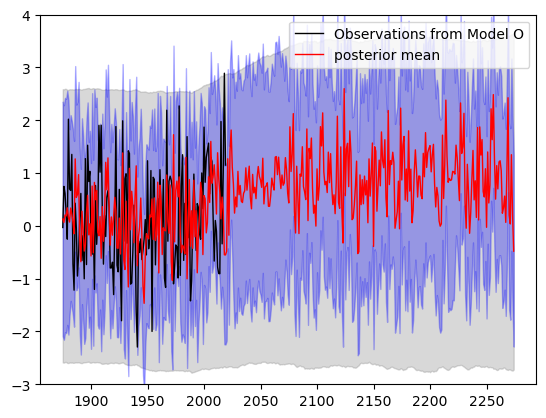

In [31]:
prior_std = np.sqrt(np.diag(prior_cov_bayes_opt))
post_std = np.sqrt(np.diag(post_cov_bayes_opt))

plt.figure()

FiveYrDf = YrDf_cmip5

#plot observations from model O  (1850 -2020)
plt.plot(FiveYrDf["years"][:Nobs].values, oos_gcm[:Nobs], 'k', lw = 1, label='Observations from Model O')

# plot prior mean and 95% CI  (1850 - 2099)
plt.fill_between(FiveYrDf["years"].values, prior_mu_bayes_opt - 1.96*prior_std, prior_mu_bayes_opt + 1.96*prior_std, alpha=0.3,color='gray')

# only plot post mean for prediction year (after 2000)
t_pred = FiveYrDf["years"].values[Nobs:]
post_mu_pred = post_mu_pso_opt[Nobs:]
post_std_pred = post_std[Nobs:]

# plot post mean for the whole study period
t_pred = FiveYrDf["years"].values
post_mu_pred = post_mu_bayes_opt
post_std_pred = post_std

plt.fill_between(t_pred, post_mu_pred - 1.96*post_std_pred, post_mu_pred + 1.96*post_std_pred, alpha=0.3,color='blue')
plt.plot(t_pred, post_mu_pred ,'r', lw = 1, label='posterior mean')
plt.ylim(-3, 4)

plt.legend()
plt.show()

# Correlation with ENSO

In [68]:
enso = pd.read_excel('../data/ENSO/ENSO_index_yearly.xlsx')

In [70]:
data = pd.read_csv('../data/week2//YrDf_cmip5_2300.csv')

# Calculate the mean of the 15 models
model_columns = [col for col in data.columns if col.startswith('model')]
model_mean = data[model_columns].mean(axis=1)

# Extract the years column
years = data['years']

# Filter the data for the years 1870 to 2023
filtered_data = model_mean[(years >= 1870) & (years <= 2023)]
filtered_years = years[(years >= 1870) & (years <= 2023)]

# Print the filtered data
print(filtered_data.head())
print(filtered_years.head())

# If you need the filtered data as a DataFrame
filtered_df = pd.DataFrame({'years': filtered_years, 'model_mean': filtered_data})
print(filtered_df.head())

0   -0.429022
1   -0.075470
2    0.095355
3   -0.088333
4   -0.005618
dtype: float64
0    1875
1    1876
2    1877
3    1878
4    1879
Name: years, dtype: int64
   years  model_mean
0   1875   -0.429022
1   1876   -0.075470
2   1877    0.095355
3   1878   -0.088333
4   1879   -0.005618


In [90]:
data = pd.read_csv('../data/week2//YrDf_cmip5_2300.csv')
enso_data = pd.read_excel('../data/ENSO/ENSO_index_yearly.xlsx')

In [92]:
years = data['years']

# Filter the data for the years 1870 to 2023
filtered_data = data[(years >= 1870) & (years <= 2023)]
filtered_years = filtered_data['years']
filtered_data

,years,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,model_11,model_12,model_13,model_14,model_15
0,1875,-0.030201,1.063186,0.819089,-0.258966,-1.294383,-1.322708,-1.682490,0.787112,-0.694233,-0.601572,-1.425760,-1.001183,-1.460050,-1.082570,1.244272,0.076104
1,1876,0.748215,-0.567122,0.200702,-0.684366,-2.473091,-0.728954,1.000202,1.270939,-0.173343,0.045697,0.624418,0.048011,-0.478581,-0.196211,-0.154877,0.310843
2,1877,0.616387,-0.642974,-2.163925,2.119356,0.083858,1.205171,0.122969,-1.145630,0.825325,-1.626903,1.460715,-0.345251,-0.362544,-0.153591,-0.262410,1.795133
3,1878,0.244487,1.179965,0.492212,1.032967,0.082436,-0.562930,-0.958975,-0.203594,0.673849,0.588461,-0.024017,-0.058898,2.128490,-2.932302,-2.470600,-0.624879
4,1879,-0.251457,-1.363517,0.098278,1.405515,-0.093115,-0.440323,-1.174225,1.651659,1.202409,0.146836,-1.418209,-0.205862,-0.955115,0.374352,0.209996,0.722895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,2019,1.151289,1.553451,-1.211471,1.077690,0.567864,-2.461439,-1.161556,1.878537,-2.061128,1.505807,1.041219,0.594556,0.041398,1.641844,0.808381,-0.539523
145,2020,-0.067877,-0.162627,0.115024,0.589817,0.367059,-1.016243,-0.502547,-0.560177,-2.142697,0.480534,-1.210624,-0.130801,-1.285185,1.832511,1.839138,-0.875105
146,2021,-0.733278,0.271683,-0.017471,-0.850759,0.410702,-2.836427,-0.664818,0.518105,-1.781956,1.785639,0.314864,0.891560,0.817167,0.112847,1.905714,-1.557013
147,2022,0.695186,1.574022,-0.496029,-0.374012,2.021966,-3.486716,0.893355,0.258623,-0.311935,-0.589720,-0.979976,1.600117,0.704186,1.621748,1.928395,-0.265765


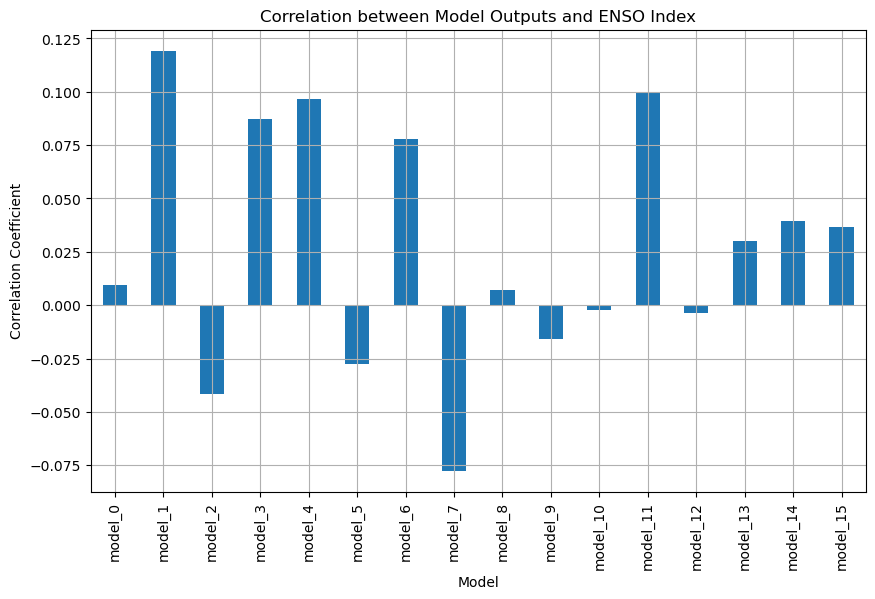

In [93]:
aligned_enso_data = enso_data[enso_data['Year'].isin(filtered_years)]
filtered_data = filtered_data[filtered_years.isin(aligned_enso_data['Year'])]
filtered_years = filtered_years[filtered_years.isin(aligned_enso_data['Year'])]

# Compute correlation coefficients
correlation_results = {}
for col in filtered_data.columns:
    if col.startswith('model'):
        correlation = filtered_data[col].corr(aligned_enso_data['Value'])
        correlation_results[col] = correlation

# Convert correlation results to a DataFrame for visualization
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Correlation'])

# Plot the correlation results
plt.figure(figsize=(10, 6))
correlation_df['Correlation'].plot(kind='bar')
plt.xlabel('Model')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation between Model Outputs and ENSO Index')
plt.grid(True)
plt.show()